#CV 전체 과정

In [1]:
pip install opencv-python-headless matplotlib numpy

     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 60.8/60.8 kB 1.6 MB/s eta 0:00:00
     ---------------------------------------- 0.0/169.3 kB ? eta -:--:--
     ------------------------------------- 169.3/169.3 kB 10.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/39.4 MB ? eta -:--:--
   ---------------------------------------- 0.1/39.4 MB ? eta -:--:--
   ---------------------------------------- 0.2/39.4 MB 3.5 MB/s eta 0:00:12
   ---------------------------------------- 0.2/39.4 MB 1.6 MB/s eta 0:00:25
   ---------------------------------------- 0.3/39.4 MB 2.0 MB/s eta 0:00:20
   ---------------------------------------- 0.5/39.4 MB 2.2 MB/s eta 0:00:18
    --------------------------------------- 0.8/39.4 MB 3.0 MB/s eta 0:00:14
   - -------------------------------------- 1.4/39.4 MB 4.4 MB/s eta 0:00:09
   -- ------------------------------------- 2.8/39.4 MB 7.9 MB/s eta 0:00:05
   ----- -------


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\Brand\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


레이블 데이터가 저장되었습니다: C:\Aiffelthon\Q-FitProj\ModelTraining\Image&TextResult\billiard_label.txt
결과 이미지가 저장되었습니다: C:\Aiffelthon\Q-FitProj\ModelTraining\Image&TextResult\billiard_result.png


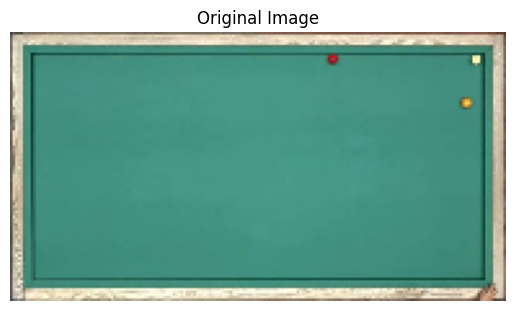

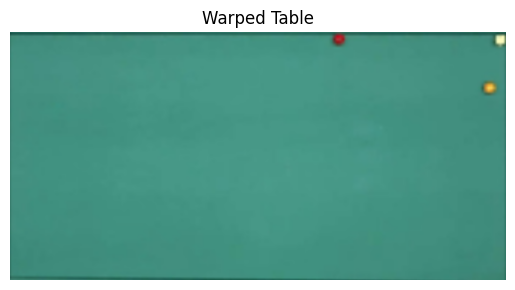

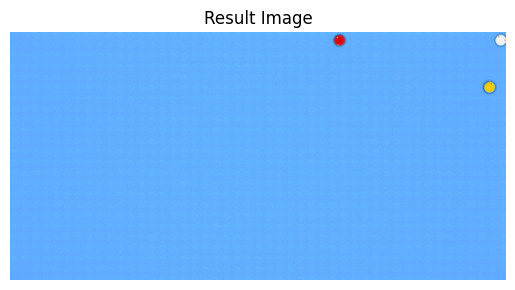

In [8]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

# 설정 값
WIDTH = 840  # 출력될 테이블 이미지의 너비
HEIGHT = 420  # 출력될 테이블 이미지의 높이

# 색깔별 HSV(Hue, Saturation, Value) 범위
color_ranges = {
    "red_ball": ((0, 120, 70), (10, 255, 255)),
    "white_ball": ((0, 0, 180), (180, 80, 255)),
    "yellow_ball": ((15, 100, 100), (40, 255, 255))
}

# 공 이미지 경로
ball_images = {
    "red_ball": r"C:\Aiffelthon\Q-FitProj\ModelTraining\CommonData\TableSourceImage\red_ball.png",
    "white_ball": r"C:\Aiffelthon\Q-FitProj\ModelTraining\CommonData\TableSourceImage\white_ball.png",
    "yellow_ball": r"C:\Aiffelthon\Q-FitProj\ModelTraining\CommonData\TableSourceImage\yellow_ball.png"
}


# Matplotlib로 이미지 표시
def show_image(img, title="Image"):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()


def find_corners(src, debug=False):
    """
    이미지에서 테이블의 모서리를 찾습니다.

    Args:
        src (np.ndarray): 입력 이미지.
        debug (bool): 디버그 모드 여부.

    Returns:
        np.ndarray: 모서리 좌표 배열.
    """
    src_hsv = cv2.cvtColor(src, cv2.COLOR_BGR2HSV)  # HSV 색 공간으로 변환

    # 파란색과 녹색 범위에 대한 마스크 생성
    table_img_blue = cv2.inRange(src_hsv, (100, 100, 100), (120, 255, 255))
    table_img_green = cv2.inRange(src_hsv, (40, 40, 40), (90, 255, 255))
    table_img = cv2.bitwise_or(table_img_blue, table_img_green)  # 마스크 합치기

    # 모폴로지 연산 (닫기)
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    table_img_closing = cv2.morphologyEx(table_img, cv2.MORPH_CLOSE, k)

    # 외곽선 찾기
    contours, _ = cv2.findContours(table_img_closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print("컨투어를 찾을 수 없습니다!")
        return None

    contour = max(contours, key=lambda x: cv2.contourArea(x))  # 가장 큰 컨투어 선택

    # 다각형 근사화
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    if len(approx) != 4:
        print('테이블 인식 실패! 충분한 점을 찾을 수 없습니다.')
        return None

    return approx  # 모서리 좌표 반환


def get_warped_table(src, approx):
    """
    원근 변환을 적용하여 테이블 이미지를 워프합니다.

    Args:
        src (np.ndarray): 입력 이미지.
        approx (np.ndarray): 모서리 좌표 배열.

    Returns:
        np.ndarray: 워프된 테이블 이미지.
    """
    if approx is None:
        print("유효한 모서리가 없으므로 테이블을 워프할 수 없습니다.")
        return None

    # 원근 변환을 위한 소스 및 대상 점 설정
    side_length = [np.linalg.norm(approx[i][0] - approx[i + 1][0]) for i in range(-1, 3)]
    upper_left_point_idx = min(range(4), key=lambda i: approx[i][0][0] + approx[i][0][1])

    if side_length[upper_left_point_idx] > side_length[(upper_left_point_idx + 1) % 4]:
        si = upper_left_point_idx
    else:
        si = (upper_left_point_idx + 1) % 4

    src_point = np.array([approx[si][0], approx[(si + 1) % 4][0], approx[(si + 2) % 4][0], approx[(si + 3) % 4][0]],
                        dtype=np.float32)
    dst_point = np.array([[0, 0], [0, HEIGHT - 1], [WIDTH - 1, HEIGHT - 1], [WIDTH - 1, 0]], dtype=np.float32)

    # 원근 변환 행렬 계산 및 적용
    matrix = cv2.getPerspectiveTransform(src_point, dst_point)
    dst = cv2.warpPerspective(src, matrix, (WIDTH, HEIGHT))[10:-10, 20:-20]

    return dst, matrix


def find_balls(img):
    """
    이미지에서 공을 찾고 위치를 반환합니다.

    Args:
        img (np.ndarray): 입력 이미지.

    Returns:
        dict: 공의 색깔별 좌표.
    """
    ball_positions = {}
    for color, (lower, upper) in color_ranges.items():
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(img_hsv, lower, upper)
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            M = cv2.moments(largest_contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                ball_positions[color] = (cx, cy)

    return ball_positions


def place_balls_on_table(table_img, ball_positions):
    """
    테이블 이미지에 공을 배치합니다.

    Args:
        table_img (np.ndarray): 테이블 이미지.
        ball_positions (dict): 공의 색깔별 좌표.

    Returns:
        np.ndarray: 공이 배치된 테이블 이미지.
    """
    result_img = table_img.copy()
    for color, path in ball_images.items():
        ball_img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        if color in ball_positions:
            cx, cy = ball_positions[color]
            bh, bw = ball_img.shape[:2]

            # 공이 배치될 영역 계산
            y1, y2 = max(0, cy - bh // 2), min(result_img.shape[0], cy + bh // 2)
            x1, x2 = max(0, cx - bw // 2), min(result_img.shape[1], cx + bw // 2)

           # 공 이미지의 크기 조정
            ball_region = ball_img[0:y2 - y1, 0:x2 - x1]

            if ball_img.shape[2] == 4:  # 알파 채널 처리
                alpha_ball = ball_img[:, :, 3] / 255.0
                alpha_ball = alpha_ball[0:y2 - y1, 0:x2 - x1]
                for c in range(3):
                    result_img[y1:y2, x1:x2, c] = (1 - alpha_ball) * result_img[y1:y2, x1:x2, c] + alpha_ball * \
                                                   ball_region[:, :, c]
            else:  # 알파 채널이 없는 경우
                result_img[y1:y2, x1:x2] = ball_region

    return result_img

def main():
    """
    전체 프로세스를 실행합니다.
    """
    # 원본 이미지 불러오기
    src_path = r"C:\Aiffelthon\Q-FitProj\DataCollection&Preprocessing\DataCollection\ViewImage\TopViewImage\top_view_image_04.jpg"
    # 테이블 이미지에 공 배치
    table_path = r"C:\Aiffelthon\Q-FitProj\ModelTraining\CommonData\TableSourceImage\billiard_cloth.png"
    # 레이블 데이터 저장
    label_file = r"C:\Aiffelthon\Q-FitProj\ModelTraining\Image&TextResult\billiard_label.txt"
    # 결과 이미지 저장
    result_path = r"C:\Aiffelthon\Q-FitProj\ModelTraining\Image&TextResult\billiard_result.png"

    # 원본 이미지 경로 유효성 검사
    if not os.path.exists(src_path):
        print(f"이미지 경로가 잘못되었습니다: {src_path}")
        return

    src = cv2.imread(src_path)
    if src is None:
        print(f"이미지를 불러오지 못했습니다: {src_path}")
        return

    src = cv2.resize(src, (int(src.shape[1] * 0.15), int(src.shape[0] * 0.15)))

    # 테이블 모서리 찾기
    approx = find_corners(src)
    if approx is None:
        print("테이블의 모서리를 찾을 수 없습니다.")
        return

    # 테이블 이미지 원근 변환
    warped_table, matrix = get_warped_table(src, approx)
    if warped_table is None:
        print("테이블 이미지를 변환하지 못했습니다.")
        return

    # 공 찾기
    ball_positions = find_balls(warped_table)
    if not ball_positions:
        print("공을 찾을 수 없습니다.")
        return

    # 레이블 데이터 저장
    os.makedirs(os.path.dirname(label_file), exist_ok=True)
    with open(label_file, "w") as f:
        for color, (cx, cy) in ball_positions.items():
            f.write(f"{color} {cx} {cy}\n")
    print(f"레이블 데이터가 저장되었습니다: {label_file}")

    # 테이블 이미지 경로 유효성 검사
    if not os.path.exists(table_path):
        print(f"테이블 이미지 경로가 잘못되었습니다: {table_path}")
        return

    # 테이블 이미지 불러오기
    table_image = cv2.imread(table_path)
    if table_image is None:
        print(f"테이블 이미지를 불러오지 못했습니다: {table_path}")
        return

    # 테이블 이미지에 공 배치
    result_image = place_balls_on_table(table_image, ball_positions)

    # 결과 이미지 저장
    os.makedirs(os.path.dirname(result_path), exist_ok=True)
    cv2.imwrite(result_path, result_image)
    print(f"결과 이미지가 저장되었습니다: {result_path}")

    # 이미지 표시
    show_image(src, "Original Image")
    show_image(warped_table, "Warped Table")
    show_image(result_image, "Result Image")


if __name__ == "__main__":
    main()
